In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Reference - > https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/

In [8]:
import sys
sys.path.insert(0, '../src/')
from models.stock_model import Stock
from api.lobster_api import stock_api
from api.technical_analysis import TechnicalAnalysis
from postgres_db import PostgresDB

In [9]:
stock_df = PostgresDB.query_to_df("select * from stock where symbol = 'AAPL'")
stock_symbols = stock_df['symbol'].to_list()

In [10]:
def compute_tech_analytics_for_stocks(stock_lst):
        tech_analytics_df = pd.DataFrame()
        for index, stock_symbol in enumerate(stock_lst):
            print('Symbol - ', index, '. ',  stock_symbol)
            try:
                # Stock Quotes
                json = PostgresDB.query_to_df("select * from stock_historical_quote where symbol = '" + stock_symbol + "'" )['historical_quote'].iloc[0]
                temp_quote_df = pd.read_json(json)[['symbol', 'date', 'open', 'high', 'low', 'close', 'adjustedClose', 'volume']]
                temp_quote_df['date'] = temp_quote_df['date'].astype({'date': 'datetime64[ns]'})
                df = temp_quote_df[['date', 'symbol', 'adjustedClose']]
                # Temp Dataframes for TechnicalAnalysis
                temp_stock_moving_averages = TechnicalAnalysis.moving_averages(df)[['date', 'symbol', 'sma_20', 'sma_200', 'ema_20', 'ema_200', 'cum_ma', 'adjustedClose']]
                temp_bollinger_bands = TechnicalAnalysis.bollinger_bands(df)[['date', 'symbol', 'bollinger_upper', 'bollinger_lower']]
                temp_rsi_calc = TechnicalAnalysis.rsi_calc(df)[['date', 'symbol', 'rsi']]
                # Return TechnicalAnalysis Dataframe
                temp_tech_analytics_df =  temp_stock_moving_averages.merge(temp_bollinger_bands, on=['date', 'symbol']).merge(temp_rsi_calc, on=['date', 'symbol'])
                #print('Symbol ', stock_symbol, ' Complete.')
                tech_analytics_df = tech_analytics_df.append(temp_tech_analytics_df)
            except:
                print('Symbol ', stock_symbol, ' Errored.')
        return tech_analytics_df

In [11]:
tech_analytics_df = compute_tech_analytics_for_stocks(stock_symbols)
tech_analytics_df

Symbol -  0 .  AAPL


,date,symbol,sma_20,sma_200,ema_20,ema_200,cum_ma,adjustedClose,bollinger_upper,bollinger_lower,rsi
0,2022-03-08,AAPL,166.070493,152.153346,161.907272,153.581183,152.153346,156.731227,183.572857,148.568129,42.759934
1,2022-03-07,AAPL,165.117801,152.284760,161.748958,153.620492,152.185333,158.582854,182.063592,148.172010,45.223866
2,2022-03-04,AAPL,164.563309,152.435087,161.781649,153.689570,152.236077,162.435431,181.093035,148.033582,50.042380
3,2022-03-03,AAPL,164.146195,152.589946,161.957848,153.781716,152.301326,165.481656,180.132213,148.160177,53.523734
4,2022-03-02,AAPL,163.588218,152.736496,162.141301,153.875442,152.367546,165.810170,178.486967,148.689470,53.896859
...,...,...,...,...,...,...,...,...,...,...,...
5619,1999-11-05,AAPL,0.721198,0.814733,0.744758,0.653433,28.459252,0.672034,0.825853,0.616543,40.897258
5620,1999-11-04,AAPL,0.709258,0.814071,0.739595,0.653348,28.454471,0.636344,0.793417,0.625100,36.593446
5621,1999-11-03,AAPL,0.698342,0.813368,0.733910,0.653183,28.449689,0.620210,0.767978,0.628706,34.810192
5622,1999-11-02,AAPL,0.689663,0.812507,0.728043,0.652972,28.444908,0.610698,0.757538,0.621788,33.765375


# Prediction

In [5]:
# Predicting Quotes
df = pd.DataFrame(data = tech_analytics_df[tech_analytics_df["symbol"] == 'AAPL'][['date', 'adjustedClose']])
df.index = df.date
df.drop(columns='date', inplace=True)
df.rename(columns= {"adjustedClose": "Quote"}, inplace=True)
df['Quote_Diff'] = df['Quote'].diff()
df['Quote_Pctchange'] = df['Quote'].pct_change()
df.dropna(inplace=True)
df.sort_index(inplace=True)
df.head(5)

KeyError: 'symbol'

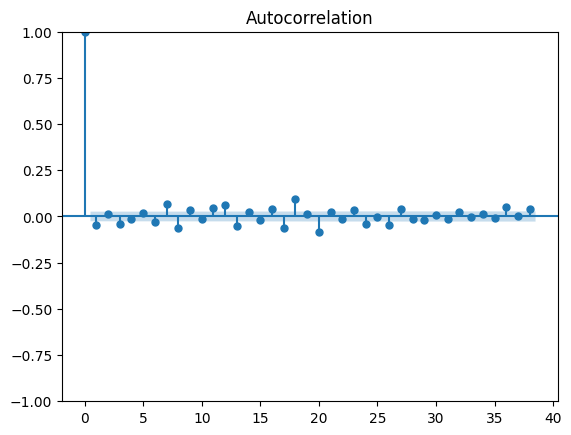

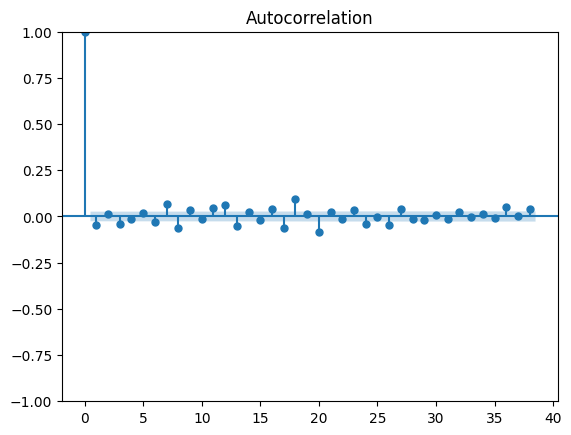

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Quote_Diff'])

In [ ]:
df = df[df.index.year>2020]
X = df['Quote'].values
split_spot = int(0.8*len(X))
train, test = X[0: split_spot], X[split_spot:]
len(train), len(test)

(236, 60)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)


Coefficients: [-0.82419484  0.9725152  -0.01505694 -0.05806287  0.2447626  -0.14675224
  0.18205596 -0.12834456 -0.13898602  0.06229821  0.06975254  0.04253811
 -0.0011647  -0.13883808  0.10453679  0.03649365  0.04695105 -0.2319499
  0.02968535  0.07208156 -0.17871568  0.10412117  0.08564587 -0.01750292
  0.05740708 -0.13587327  0.06818136 -0.01575028  0.01149361  0.02399886]


Test RMSE: 19.617


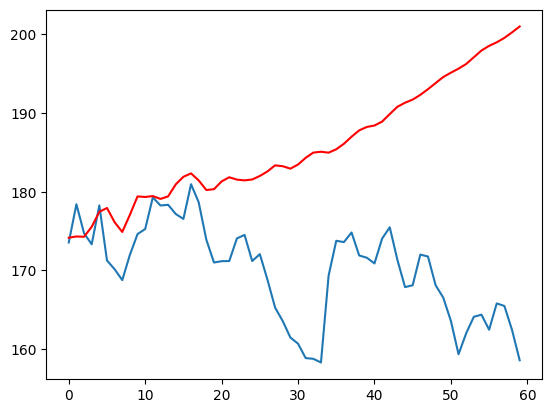

In [ ]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 19.617


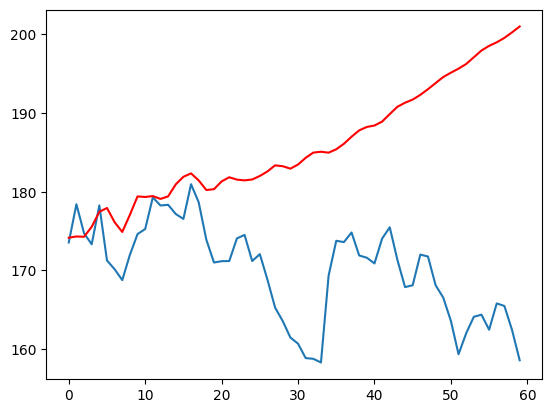

In [ ]:
#Make Predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
len(test), len(predictions)

(60, 60)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

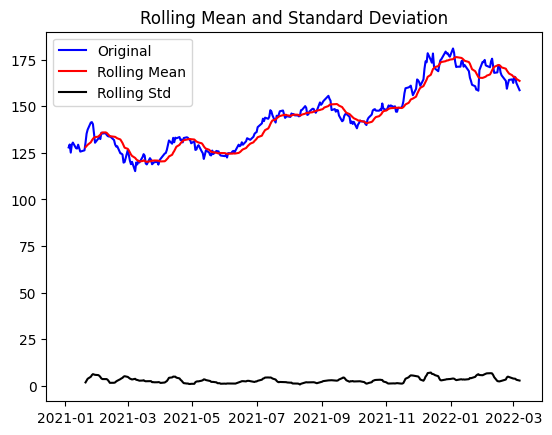

Results of dickey fuller test
Test Statistics                 -1.212495
p-value                          0.668198
No. of lags used                 0.000000
Number of observations used    295.000000
critical value (1%)             -3.452713
critical value (5%)             -2.871388
critical value (10%)            -2.572017
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)


test_stationarity(df['Quote'])

<Figure size 640x480 with 0 Axes>

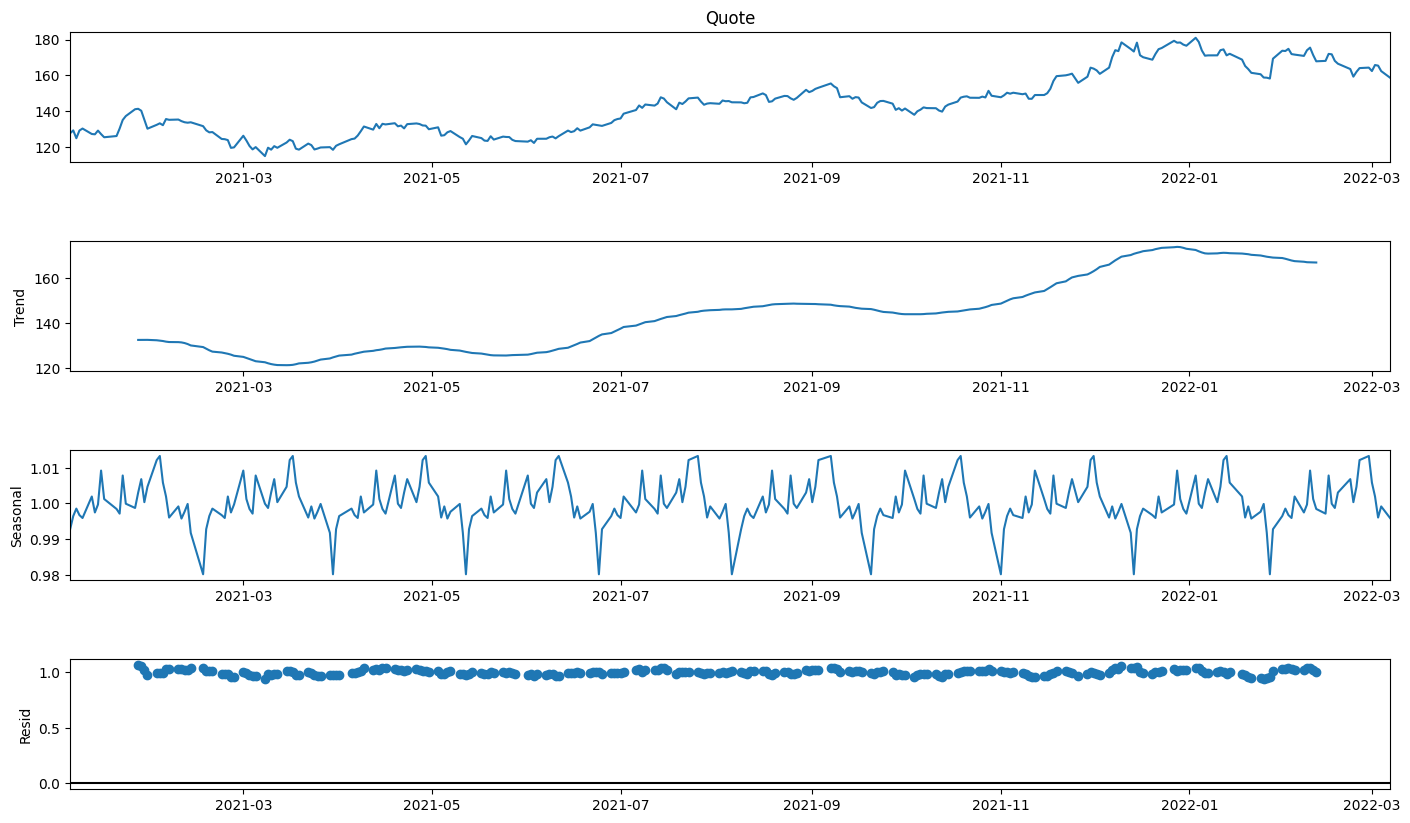

In [ ]:
result = seasonal_decompose(df['Quote'], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


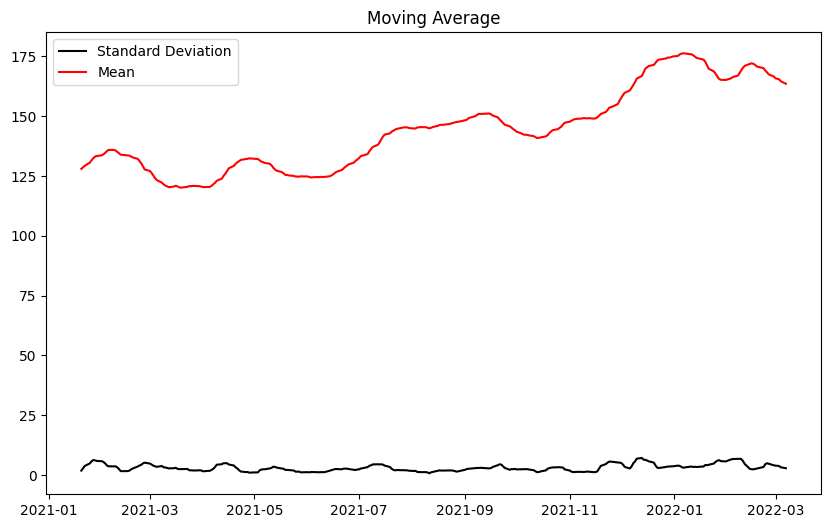

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
import numpy as np
rcParams['figure.figsize'] = 10, 6
df_log = df['Quote']
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


In [ ]:
df

,Quote,Quote_Diff,Quote_Pctchange
date,,,
2021-01-04,127.875200,-1.581024,-0.012213
2021-01-05,129.456224,4.357698,0.034834
2021-01-06,125.098527,-4.268765,-0.032997
2021-01-07,129.367292,-1.116598,-0.008557
2021-01-08,130.483890,3.033590,0.023802
...,...,...,...
2022-03-01,162.465296,-3.344874,-0.020173
2022-03-02,165.810170,0.328514,0.001985
2022-03-03,165.481656,3.046224,0.018753


266
266 30


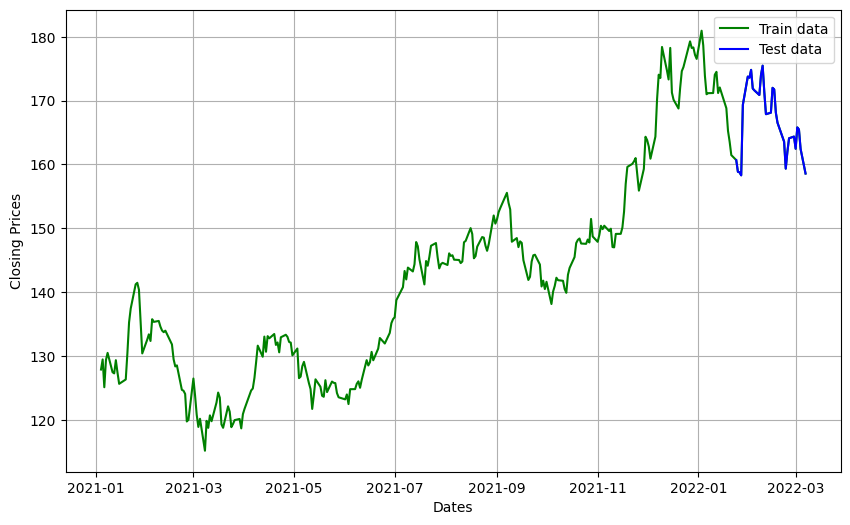

In [ ]:
print(int(len(df_log)*0.9))
#split data into train and training set
train_data, test_data = df_log[0:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
print(len(train_data), len(test_data))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1180.432, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1182.423, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1182.422, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1179.289, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1184.281, Time=0.78 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.370 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  266
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -588.644
Date:                Sat, 11 Feb 2023   AIC                           1179.289
Time:                        22:15:06   BIC                           1182.869
Sample:                             0   HQIC                          1180.727
                                - 266                                       

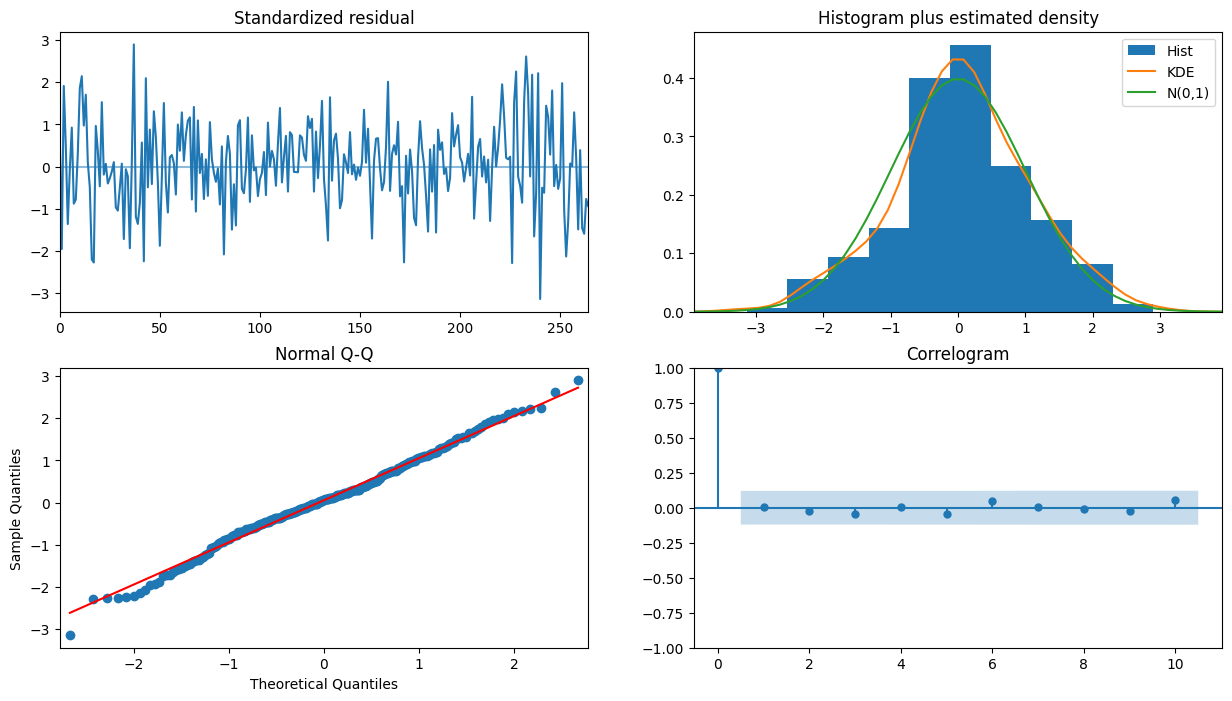

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
import statsmodels
#Modeling
# Build Model
model = statsmodels.tsa.arima.model.ARIMA(train_data, order=(2,1,2))  
fitted = model.fit()  
print(fitted.summary())

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
                               SARIMAX Results                                
Dep. Variable:                  Quote   No. Observations:                  266
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -584.840
Date:           

In [ ]:
forecast_values_df = fitted.get_prediction().summary_frame()
forecast_values_df = forecast_values_df[1:]


In [ ]:
fitted.




In [ ]:
fitted.get_forecast().summary_frame()

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Quote,mean,mean_se,mean_ci_lower,mean_ci_upper
266,161.482325,2.1909,157.18824,165.77641


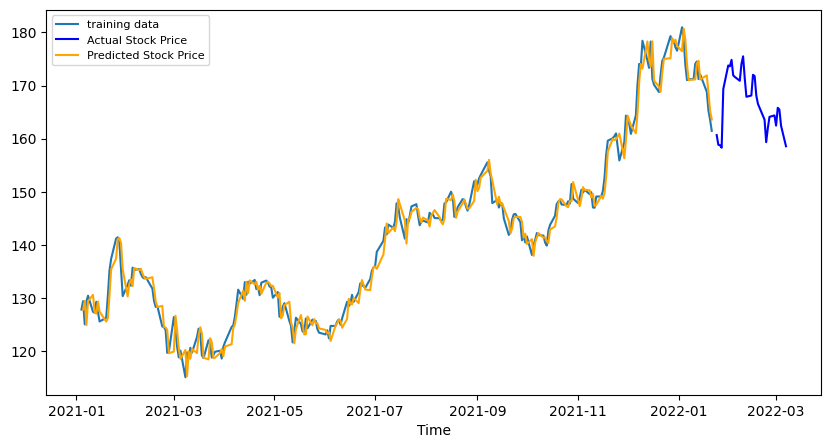

In [ ]:
# Make as pandas series
fc_series = pd.Series(forecast_values, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(forecast_values_df['mean'], color = 'orange',label='Predicted Stock Price')

plt.xlabel('Time')
plt.legend(loc='upper left', fontsize=8)
plt.show()



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=47acbe2e-cf49-4a5d-8910-b2139b3d8d7c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>